In [27]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

# Data Preprocessing

## Helper class to create the one-hot vectors for our dataset.

In [43]:
SOS_token = 0 #start of sentence
EOS_token = 1 #end of sentence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Preprocess files

Transform unicode in ascii and convert to lower case.

In [42]:
import re, unicodedata

def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

## Read file

Split line into pairs (english / other language)

In [44]:
def readLangs(lang1, lang2, reverse = False):
    print("Reading lines...")
    lines = open ('data/%s-%s/%s.txt'%(lang1, lang2, lang1), encoding = 'utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    else:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    return input_lang, output_lang, pairs

## Make it easier

Keep only sort sentences that translate to the form "I am", "He is", etc.

In [45]:
MAX_LENGTH = 10

eng_prefixes = ('i am ', 'i m ','you are ', 'you re ', 'he is ', ' he s ', 'she is ', 'she s ', 'we are ', 'we re ', 'they are ', 'they re ')

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

## Full preprocess

In [46]:
import random

def prepareData(lang1, lang2, reverse = False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print('Read %d sentence pairs'%len(pairs))
    pairs = filterPairs(pairs)
    print('Trimmed to %d sentence pairs'%len(pairs))
    print('Counting words...')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('fra', 'eng', True)
example = random.choice(pairs)
print(example)

Reading lines...
Read 149861 sentence pairs
Trimmed to 10535 sentence pairs
Counting words...
Counted words:
fra 4279
eng 2737
['je ne suis pas un grand photographe .', 'i m not a great photographer .']


In [2]:
example = ['nous sommes fatigues .', 'we re helpless .']

# Seq2seq model

## Encoder

In [48]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

USE_CUDA = False
INPUT_SIZE = input_lang.n_words
HIDDEN_SIZE = 256
OUTPUT_SIZE = output_lang.n_words

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda()
        else:
            return result
        
encoder = EncoderRNN(INPUT_SIZE,HIDDEN_SIZE)

## Decoder with Attention

In [56]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size *2, max_length)
        self.attn_combine = nn.Linear(hidden_size*2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        
    def forward(self,input,hidden,encoder_outputs):
#         embedded = self.embedding(input).view(1,1,-1)
#         embedded = self.dropout(embedded) #1, 1, 256
#         # prev_hidden: 1, 1, 256
#         attn_weights = self.attn(torch.cat([embedded,prev_hidden],2)) #1, 1, 10
#         attn_weights = F.softmax(attn_weights,dim=2) #1, 1, 10
#         encoder_outputs = encoder_outputs.unsqueeze(0) #1, 10, 256
#         attn_applied = torch.bmm(attn_weights,encoder_outputs) # 1, 1, 256
#         output = self.attn_combine(torch.cat([embedded,attn_applied],2)) #1, 1, 256
#         output = F.relu(output) #1, 1, 256
#         output, hidden = self.gru(output,prev_hidden) #1, 1, 256 ; 1, 1, 256
#         output = self.out(output)
#         output = F.softmax(output,dim=1)
#         return output[0], hidden, attn_weights #1, 1, 256 ; 1, 1, 256 ; 1, 1, 10

        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        result = Variable(torch.zeros(1,1,self.hidden_size))
        if USE_CUDA:
            return result.cuda()
        else:
            return result

## Test

In [21]:
input_var, target_var = example[0], example[1]
encoder = EncoderRNN(INPUT_SIZE,HIDDEN_SIZE)
encoder_hidden = encoder.initHidden()
input_length = input_var.size()[0]
encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
encoder_outputs = encoder_outputs.cuda() if USE_CUDA else encoder_outputs
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_var[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0][0]     
print(encoder_outputs)

decoder = AttnDecoderRNN(HIDDEN_SIZE,OUTPUT_SIZE)
decoder_hidden = decoder.initHidden()
target_length = target_var.size()[0]
loss = 0
decoder_input = Variable(torch.LongTensor([[SOS_token]]))
decoder_input = decoder_input.cuda() if USE_CUDA else decoder_input
criterion = nn.NLLLoss()

# Feed the target as the next input
for di in range(target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
    loss += criterion(decoder_output, target_var[di])
    decoder_input = target_var[di]
print(loss)

Variable containing:
 0.0456 -0.3023  0.0939  ...  -0.1898  0.1138  0.3477
-0.1817  0.3257  0.0793  ...  -0.5152 -0.2456  0.0447
-0.2697 -0.0340  0.3473  ...  -0.4264 -0.1177 -0.0347
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 10x256]

Variable containing:
 39.9401
[torch.FloatTensor of size 1]



# Training

## Prepare data

Get one hot vectors for each word in sentence.

In [58]:
def indexesFromSentence(lang,sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang,sentence):
    indexes = indexesFromSentence(lang,sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1,1))
    if USE_CUDA:
        return result.cuda()
    else:
        return result
    
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang,pair[0])
    target_variable = variableFromSentence(output_lang,pair[1])
    return (input_variable, target_variable)

input_var, target_var = variablesFromPair(example)

## Training with teacher forcing

In [61]:
TEACHER_FORCING_RATIO = 0.5
import torch.optim as optim

def train(input_var, target_var, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()
    decoder_hidden = encoder_hidden
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_var.size()[0]
    target_length = target_var.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if USE_CUDA else encoder_outputs
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_var[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if USE_CUDA else decoder_input
    
    use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False
    
    if use_teacher_forcing:
        # Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_var[di])
            decoder_input = target_var[di]
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_var[di])
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if USE_CUDA else decoder_input
            if ni == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

encoder_opt = optim.SGD(encoder.parameters(), lr=0.01)
decoder_opt = optim.SGD(encoder.parameters(), lr=0.01)
train(input_var,target_var,encoder,decoder,encoder_opt,decoder_opt,nn.NLLLoss())

7.960744380950928

## Keep track of time

In [23]:
import time, math

def asMinutes(s):
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m,s)

def timeSince(since,percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s),asMinutes(rs))

## Plot results

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
#     plt.figure()
#     fig, ax = plt.subplots()
#     # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
#     plt.plot(points)    
    plt.figure()
    plt.plot(points)
    plt.show()

## Full training process

In [75]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0 # reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

0m 22s (- 7m 5s) (250 5%) 3.8547
0m 45s (- 6m 50s) (500 10%) 3.3445
1m 9s (- 6m 33s) (750 15%) 3.1302
1m 33s (- 6m 12s) (1000 20%) 3.0400
1m 57s (- 5m 52s) (1250 25%) 3.0261
2m 21s (- 5m 30s) (1500 30%) 2.9283
2m 46s (- 5m 8s) (1750 35%) 2.9453
3m 10s (- 4m 45s) (2000 40%) 2.7761
3m 35s (- 4m 23s) (2250 45%) 2.8259
3m 59s (- 3m 59s) (2500 50%) 2.6327
4m 24s (- 3m 36s) (2750 55%) 2.5856
4m 49s (- 3m 12s) (3000 60%) 2.6956
5m 14s (- 2m 49s) (3250 65%) 2.6116
5m 39s (- 2m 25s) (3500 70%) 2.7085
6m 3s (- 2m 1s) (3750 75%) 2.5469
6m 28s (- 1m 37s) (4000 80%) 2.6563
6m 53s (- 1m 12s) (4250 85%) 2.5282
7m 18s (- 0m 48s) (4500 90%) 2.4260
7m 42s (- 0m 24s) (4750 95%) 2.5467
8m 7s (- 0m 0s) (5000 100%) 2.5003


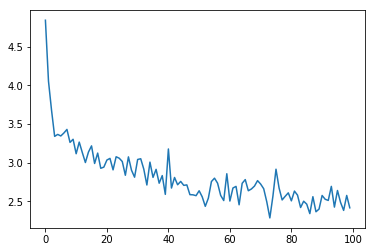

In [77]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

if USE_CUDA:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

all_losses = trainIters(encoder1, attn_decoder1, 5000, learning_rate=0.01, print_every=250, plot_every = 50)

In [ ]:
# print(all_losses)
showPlot(all_losses)

In [84]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        
    return decoded_words, decoder_attentions[:di + 1]

In [91]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(len(pairs))
        print(pair)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [92]:
evaluateRandomly(encoder1, attn_decoder1)

10535
['elles se cachent dans les bois .', 'they re hiding in the woods .']
> elles se cachent dans les bois .
= they re hiding in the woods .


TypeError: 'NoneType' object is not iterable